# Irish Weather — RNN vs LSTM vs Transformer (Dublin t2m)

This notebook compares **three simple sequence models** on Irish ERA5 data, using the same task:
**Predict the next hour of Dublin 2m temperature from the previous 24 hours.**

Data file (place beside this notebook): `era5_ireland3_t2m_wind_2024.csv`

Models:
- **RNN** (`nn.RNN`) — the simplest recurrent model
- **LSTM** (`nn.LSTM`) — adds gates + cell state
- **Transformer (Encoder)** — attention over the 24-hour context (tiny model)

We keep code short, CPU-friendly, and heavily commented, mirroring your lecture flow.


## 0) Setup

In [4]:
# %pip install pandas numpy scikit-learn torch matplotlib

import warnings, pathlib
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

CSV_PATH = "../../data/era5_ireland3_t2m_wind_2024.csv"
assert pathlib.Path(CSV_PATH).exists(), "Place era5_ireland3_t2m_wind_2024.csv next to this notebook."
device = "cpu"  # keep CPU for class

print("Using device:", device)


Using device: cpu


## 1) Load data, split by time, build 24→next windows

In [5]:
# Load
df = pd.read_csv(CSV_PATH, parse_dates=['time']).sort_values('time').reset_index(drop=True)
print(df.head(5))
print("Coverage:", df['time'].min(), "→", df['time'].max(), f"({len(df)} hourly rows)")

# Split 70/15/15 by time
n = len(df)
i_tr = int(0.70*n); i_va = int(0.85*n)
splits = {'train': (0, i_tr), 'val': (i_tr, i_va), 'test': (i_va, n)}

# We'll use **only Dublin temperature** to keep things focused and comparable
series = df[['Dublin_t2m_degC']].copy()

# Standardise with train-only stats
sc = StandardScaler().fit(series.iloc[splits['train'][0]:splits['train'][1]])
x_all = sc.transform(series.values)  # shape (N, 1)

# Build windows: past T hours → next hour
T = 24
def make_windows(x, T=24):
    Xs, ys = [], []
    for t in range(len(x)-T):
        Xs.append(x[t:t+T])   # (T, 1)
        ys.append(x[t+T])     # (1,)
    return np.stack(Xs), np.stack(ys)

X_all, y_all = make_windows(x_all, T=T)      # (M, T, 1), (M, 1)
M = len(X_all)
i_tr_w = int(0.70*M); i_va_w = int(0.85*M)

Xtr, ytr = X_all[:i_tr_w], y_all[:i_tr_w]
Xva, yva = X_all[i_tr_w:i_va_w], y_all[i_tr_w:i_va_w]
Xte, yte = X_all[i_va_w:], y_all[i_va_w:]

print("Windows:")
print("Train:", Xtr.shape, ytr.shape, "| Val:", Xva.shape, yva.shape, "| Test:", Xte.shape, yte.shape)

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)   # (N,T,1)
        self.y = torch.tensor(y, dtype=torch.float32)   # (N,1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

tr_dl = DataLoader(SeqDataset(Xtr,ytr), batch_size=128, shuffle=True)
va_dl = DataLoader(SeqDataset(Xva,yva), batch_size=256)
te_dl = DataLoader(SeqDataset(Xte,yte), batch_size=256)

def rmse_c(model, loader, scaler):
    """Compute RMSE in °C by inverting the standardisation."""
    model.eval(); P=[]; T_=[]
    with torch.no_grad():
        for xb,yb in loader:
            yh = model(xb).numpy()
            P.append(yh); T_.append(yb.numpy())
    P = np.vstack(P); T_ = np.vstack(T_)
    P_inv = scaler.inverse_transform(P); T_inv = scaler.inverse_transform(T_)
    rmse = float(np.sqrt(((P_inv - T_inv)**2).mean()))
    return rmse, P_inv, T_inv


                 time  Dublin_t2m_degC  Galway_t2m_degC  Cork_t2m_degC  \
0 2024-01-01 00:00:00         5.763580         6.396393       5.617096   
1 2024-01-01 01:00:00         5.445953         5.922516       5.094391   
2 2024-01-01 02:00:00         5.434723         5.518707       4.604645   
3 2024-01-01 03:00:00         5.265533         5.257721       4.111237   
4 2024-01-01 04:00:00         5.138092         5.163483       3.917389   

   Dublin_wind_speed10m_ms  Galway_wind_speed10m_ms  Cork_wind_speed10m_ms  
0                 8.426119                 6.120335               4.927529  
1                 8.082199                 5.639297               4.454760  
2                 7.943061                 4.928046               3.922362  
3                 7.585234                 4.344268               3.177118  
4                 7.084112                 3.941263               2.874048  
Coverage: 2024-01-01 00:00:00 → 2024-12-31 23:00:00 (8784 hourly rows)
Windows:
Train: (6132,

## 2) Baseline: Vanilla RNN (`nn.RNN`)

Epoch 01 | train MSE=0.5666 | val MSE=0.0600
Epoch 02 | train MSE=0.0578 | val MSE=0.0242
Epoch 03 | train MSE=0.0267 | val MSE=0.0161
Epoch 04 | train MSE=0.0195 | val MSE=0.0135
Epoch 05 | train MSE=0.0162 | val MSE=0.0113
Epoch 06 | train MSE=0.0140 | val MSE=0.0104
Epoch 07 | train MSE=0.0126 | val MSE=0.0093
Epoch 08 | train MSE=0.0117 | val MSE=0.0087
RNN — Test RMSE: 0.431 °C


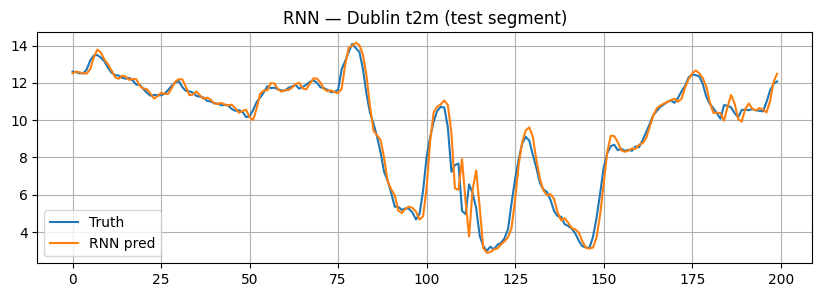

In [6]:
class TinyRNN(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        # input_size=1 (Dublin temp), sequence length = 24
        self.rnn = nn.RNN(input_size=1, hidden_size=16, nonlinearity='tanh', batch_first=True)
        self.head = nn.Linear(16, 1)
    def forward(self, x):        # x: (B, T, 1)
        out, _ = self.rnn(x)     # out: (B, T, H)
        return self.head(out[:,-1,:])  # predict from last step

torch.manual_seed(0)
model_rnn = TinyRNN().to(device)
opt = torch.optim.Adam(model_rnn.parameters(), lr=3e-3)
loss_fn = nn.MSELoss()

def eval_mse(model, loader):
    model.eval(); tot=0; n=0
    with torch.no_grad():
        for xb,yb in loader:
            yh = model(xb.to(device))
            l = loss_fn(yh, yb.to(device)).item()
            tot += l*len(xb); n += len(xb)
    return tot/n

for ep in range(8):
    model_rnn.train(); run=0; ntr=0
    for xb,yb in tr_dl:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        yh = model_rnn(xb)
        loss = loss_fn(yh, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model_rnn.parameters(), 1.0)
        opt.step()
        run += loss.item()*len(xb); ntr += len(xb)
    val = eval_mse(model_rnn, va_dl)
    print(f"Epoch {ep+1:02d} | train MSE={run/ntr:.4f} | val MSE={val:.4f}")

rmse_rnn, pred_rnn, true_rnn = rmse_c(model_rnn, te_dl, sc)
print(f"RNN — Test RMSE: {rmse_rnn:.3f} °C")

plt.figure(figsize=(10,3))
plt.plot(true_rnn[:200,0], label='Truth')
plt.plot(pred_rnn[:200,0], label='RNN pred')
plt.title('RNN — Dublin t2m (test segment)'); plt.legend(); plt.grid(True); plt.show()


## 3) LSTM (`nn.LSTM`) — same setup for fair comparison

Epoch 01 | train MSE=0.3243 | val MSE=0.0685
Epoch 02 | train MSE=0.0480 | val MSE=0.0181
Epoch 03 | train MSE=0.0193 | val MSE=0.0130
Epoch 04 | train MSE=0.0143 | val MSE=0.0106
Epoch 05 | train MSE=0.0114 | val MSE=0.0102
Epoch 06 | train MSE=0.0104 | val MSE=0.0080
Epoch 07 | train MSE=0.0091 | val MSE=0.0081
Epoch 08 | train MSE=0.0087 | val MSE=0.0073
LSTM — Test RMSE: 0.423 °C


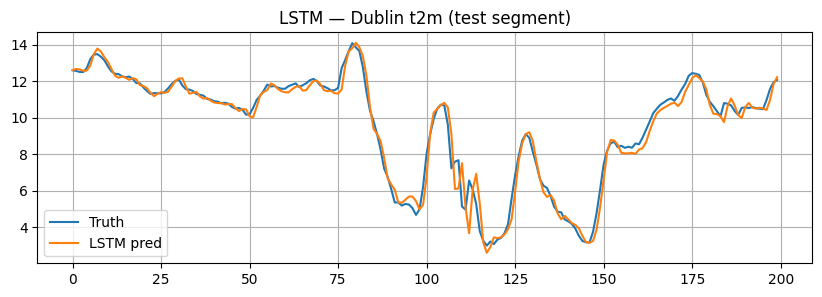

In [7]:
class TinyLSTM(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=32, batch_first=True)
        self.head = nn.Linear(32, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.head(out[:,-1,:])

torch.manual_seed(0)
model_lstm = TinyLSTM().to(device)
opt = torch.optim.Adam(model_lstm.parameters(), lr=3e-3)
loss_fn = nn.MSELoss()

for ep in range(8):
    model_lstm.train(); run=0; ntr=0
    for xb,yb in tr_dl:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        yh = model_lstm(xb)
        loss = loss_fn(yh, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model_lstm.parameters(), 1.0)
        opt.step()
        run += loss.item()*len(xb); ntr += len(xb)
    val = eval_mse(model_lstm, va_dl)
    print(f"Epoch {ep+1:02d} | train MSE={run/ntr:.4f} | val MSE={val:.4f}")

rmse_lstm, pred_lstm, true_lstm = rmse_c(model_lstm, te_dl, sc)
print(f"LSTM — Test RMSE: {rmse_lstm:.3f} °C")

plt.figure(figsize=(10,3))
plt.plot(true_lstm[:200,0], label='Truth')
plt.plot(pred_lstm[:200,0], label='LSTM pred')
plt.title('LSTM — Dublin t2m (test segment)'); plt.legend(); plt.grid(True); plt.show()


## 4) Tiny Transformer (Encoder) — attention over the 24-hour context

**Idea:** map each hour's (scaled) temperature to a small vector space, add **positional encoding** so the model knows the hour order, pass through **1–2 encoder layers**, and predict the next value.

We keep everything small to stay fast on CPU.


Epoch 01 | train MSE=0.0878 | val MSE=0.0141
Epoch 02 | train MSE=0.0113 | val MSE=0.0073
Epoch 03 | train MSE=0.0089 | val MSE=0.0067
Epoch 04 | train MSE=0.0082 | val MSE=0.0061
Epoch 05 | train MSE=0.0079 | val MSE=0.0089
Epoch 06 | train MSE=0.0070 | val MSE=0.0057
Epoch 07 | train MSE=0.0075 | val MSE=0.0059
Epoch 08 | train MSE=0.0082 | val MSE=0.0054
Epoch 09 | train MSE=0.0086 | val MSE=0.0054
Epoch 10 | train MSE=0.0084 | val MSE=0.0069
Transformer — Test RMSE: 0.392 °C


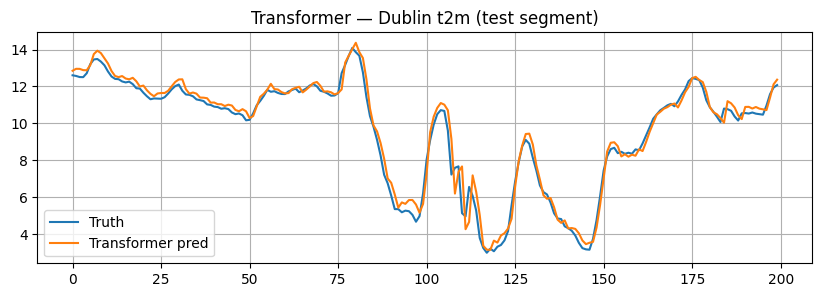

In [8]:
class PositionalEncoding(nn.Module):
    """Standard sinusoidal positional encoding (no learnable parameters)."""
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x: (B, T, d_model)
        T = x.size(1)
        return x + self.pe[:, :T, :]

class TinyTimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=32, nhead=4, num_layers=2, dim_ff=64, dropout=0.0):
        super().__init__()
        # Map scalar input (1) to d_model
        self.input_proj = nn.Linear(1, d_model)
        self.posenc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_ff, batch_first=True, dropout=dropout, activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Linear(d_model, 1)  # predict next value from last token's representation
    def forward(self, x):  # x: (B, T, 1)
        h = self.input_proj(x)        # (B, T, d_model)
        h = self.posenc(h)            # add positions
        z = self.encoder(h)           # (B, T, d_model)
        return self.head(z[:, -1, :]) # use last-step token

torch.manual_seed(0)
model_tx = TinyTimeSeriesTransformer(d_model=32, nhead=4, num_layers=2, dim_ff=64, dropout=0.0).to(device)
opt = torch.optim.Adam(model_tx.parameters(), lr=3e-3)
loss_fn = nn.MSELoss()

for ep in range(10):
    model_tx.train(); run=0; ntr=0
    for xb,yb in tr_dl:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        yh = model_tx(xb)
        loss = loss_fn(yh, yb)
        loss.backward()
        opt.step()
        run += loss.item()*len(xb); ntr += len(xb)
    val = eval_mse(model_tx, va_dl)
    print(f"Epoch {ep+1:02d} | train MSE={run/ntr:.4f} | val MSE={val:.4f}")

rmse_tx, pred_tx, true_tx = rmse_c(model_tx, te_dl, sc)
print(f"Transformer — Test RMSE: {rmse_tx:.3f} °C")

plt.figure(figsize=(10,3))
plt.plot(true_tx[:200,0], label='Truth')
plt.plot(pred_tx[:200,0], label='Transformer pred')
plt.title('Transformer — Dublin t2m (test segment)'); plt.legend(); plt.grid(True); plt.show()


## 5) Compare models

In [9]:
print(f"RNN         RMSE: {rmse_rnn:.3f} °C") 
print(f"LSTM        RMSE: {rmse_lstm:.3f} °C")
print(f"Transformer RMSE: {rmse_tx:.3f} °C")

RNN         RMSE: 0.431 °C
LSTM        RMSE: 0.423 °C
Transformer RMSE: 0.392 °C


## 6) Notes & optional extensions

- All three use the same **24→next** setup and the same scaling for a fair comparison.
- The Transformer can naturally use **multi-variate inputs** and longer contexts — try adding wind or other cities.
- If training is noisy, try:
  - a slightly smaller learning rate (e.g., `1e-3`),
  - a few more epochs (e.g., 20),
  - dropout in the Transformer (`dropout=0.1`).

**Optional exercises (for students):**
- Change `T` to 48 and see which model benefits.
- Add **hour-of-day** sine/cosine features by concatenating them to the input.
- Predict **multi-step** outputs (e.g., next 6 hours) with a small MLP head.
